# Composers of classical music in *`.midi`* format
### Chieu Le Heng and Oliver James Tan
Identifying the composer of a piece of classical music is part of many music training programmes and tests (e.g. ABRSM aural tests). While speech recognition is a popular topic in AI, less work has been done on AI in music.

Much research has been done on working with `.mp3`/`.wav` files that store the sound waves of recordings of the pieces. Some approaches to working audio files include plotting a spectrogram and running image recognition on it, or computing the MFCC (Mel-Frequency Cepstrum Coefficients) of timeframes from the audio file and classifying based on that. However, much less work has been done with `.midi` files, which only encode when a note is played and at what amplitude.

When working with midi files, different approaches have been tried. Some algorithms extract hand-crafted features from the midi-files, such as note range and frequency (https://github.com/dantasfiles/CatiMidi), inter-onset interval (http://cs229.stanford.edu/proj2012/LanSaied-MusicClassificationByComposer.pdf) or tempo and frequency [b] which we try. Other algorithms liken midi files to language, and use tools like tf-idf frequency and 

In this project, we work on a dataset of `.midi` files from http://www.kunstderfuge.com/.

First, we tried using the python library `pretty_midi` to **extract features** such as tempo from the midi files, and classified the tracks based on the results. However, the results were appallingly bad, and we got an accuracy of 42.5%. Normalising the features improved the results to 75.0%, and tuning hyperparameters boosts performance to 76.0%. This reflects that simple metrics such as tempo and time signature are sufficient to reflect composers' styles.

(For chord frequency, refer to `experiment-preprocessing.ipynb` and `experiment-classification.ipynb` for now) Next, we classify the files with using **chord frequency** and chord progression [1, 3]. In music theory, chords are groups of notes that are usually played at the same time, and chords are to notes as words are to letters. In fact, chord progessions like the imperfect cadence are very popular and often used to end a section. Hence, chords can reveal stylistic choices that the composer might have made for a piece. `tf-idf` is used on the frequency of each chord, similar to how it n-grams are computed for words in NLP (Natural Language Processing). We find this approach successful in classifying the files, getting an accuracy of 55.61%.

Having successfully classified the files, we proceeded to **cluster** and **visualise** based on chord frequency, to observe what other patterns there are between the files, an approach that has not been tried before. We notice that the songs are clustered by ___.

Lastly, we **characterise** our model, and look at what chords and chord progressions our model has attributed to each composer. This information may prove useful for music students familiarising themselves with composers' styles.

### References
[1] A. Koh. Recognising Classical Composers using High-Level Music Features

[2] https://arxiv.org/pdf/1706.08928.pdf

[3] https://github.com/robert-d-schultz/music-classification/blob/master/preprocess.py

### Code sources
[a] https://github.com/achimkoh/midi-classification

[b] https://github.com/sandershihacker/midi-classification-tutorial/blob/master/midi_classifier.ipynb

First, we download the `.midi` files that have been converted to piano roll format, and convert them back to `.midi` files.

In [1]:
!pip install pygame
!pip install pretty_midi
!pip install pypianoroll
!pip install music21
import numpy as np
import pandas as pd
import music21
#from google.colab import drive
import os
import pickle
from tqdm.notebook import *
from pypianoroll import plot, Track, Multitrack

#drive.mount('/content/drive')
#os.chdir('/content/drive/My Drive/Colab Notebooks/ClassicalPianoRolls')

In [2]:
with open('music.pk', 'rb') as file:
    music = pickle.load(file)
music[0]

{'name': 'albeniz_suite_espanola_47_02_cataluna_(c)yogore.mid',
 'composer': 'Albeniz',
 'piece': <7368x128 sparse matrix of type '<class 'numpy.float64'>'
 	with 28387 stored elements in COOrdinate format>}

# Data handling

5992
{'Albeniz': 68, 'Alkan': 249, 'Bach, J.S': 1965, 'Bartók': 17, 'Beethoven': 290, 'Brahms': 150, 'Buxtehude': 63, 'Byrd': 113, 'Chopin': 252, 'Clementi': 45, 'Couperin': 1, 'Dandrieu': 163, 'Debussy': 149, 'Dvořák': 147, 'Fauré': 96, 'Frescobaldi': 86, 'Froberger': 45, 'Gesualdo da Venosa': 37, 'Handel': 496, 'Haydn, F': 237, 'Mahler': 32, 'Mendelssohn-B': 61, 'Mozart': 568, 'Mussorgsky': 29, 'Pachelbel, J': 86, 'Praetorius': 36, 'Pres (Despres)': 29, 'Rachmaninov': 25, 'Ravel': 50, 'Reger': 32, 'Saint-Saëns': 95, 'Satie': 47, 'Scarlatti, D': 555, 'Schubert': 281, 'Schumann': 102, 'Scriabin': 27, 'Stravinsky': 39, 'Tchaikovsky': 275, 'Telemann': 60, 'Vivaldi': 36}
{'Alkan': 249, 'Bach, J.S': 1965, 'Beethoven': 290, 'Brahms': 150, 'Byrd': 113, 'Chopin': 252, 'Dandrieu': 163, 'Debussy': 149, 'Dvořák': 147, 'Handel': 496, 'Haydn, F': 237, 'Mozart': 568, 'Scarlatti, D': 555, 'Schubert': 281, 'Schumann': 102, 'Tchaikovsky': 275}


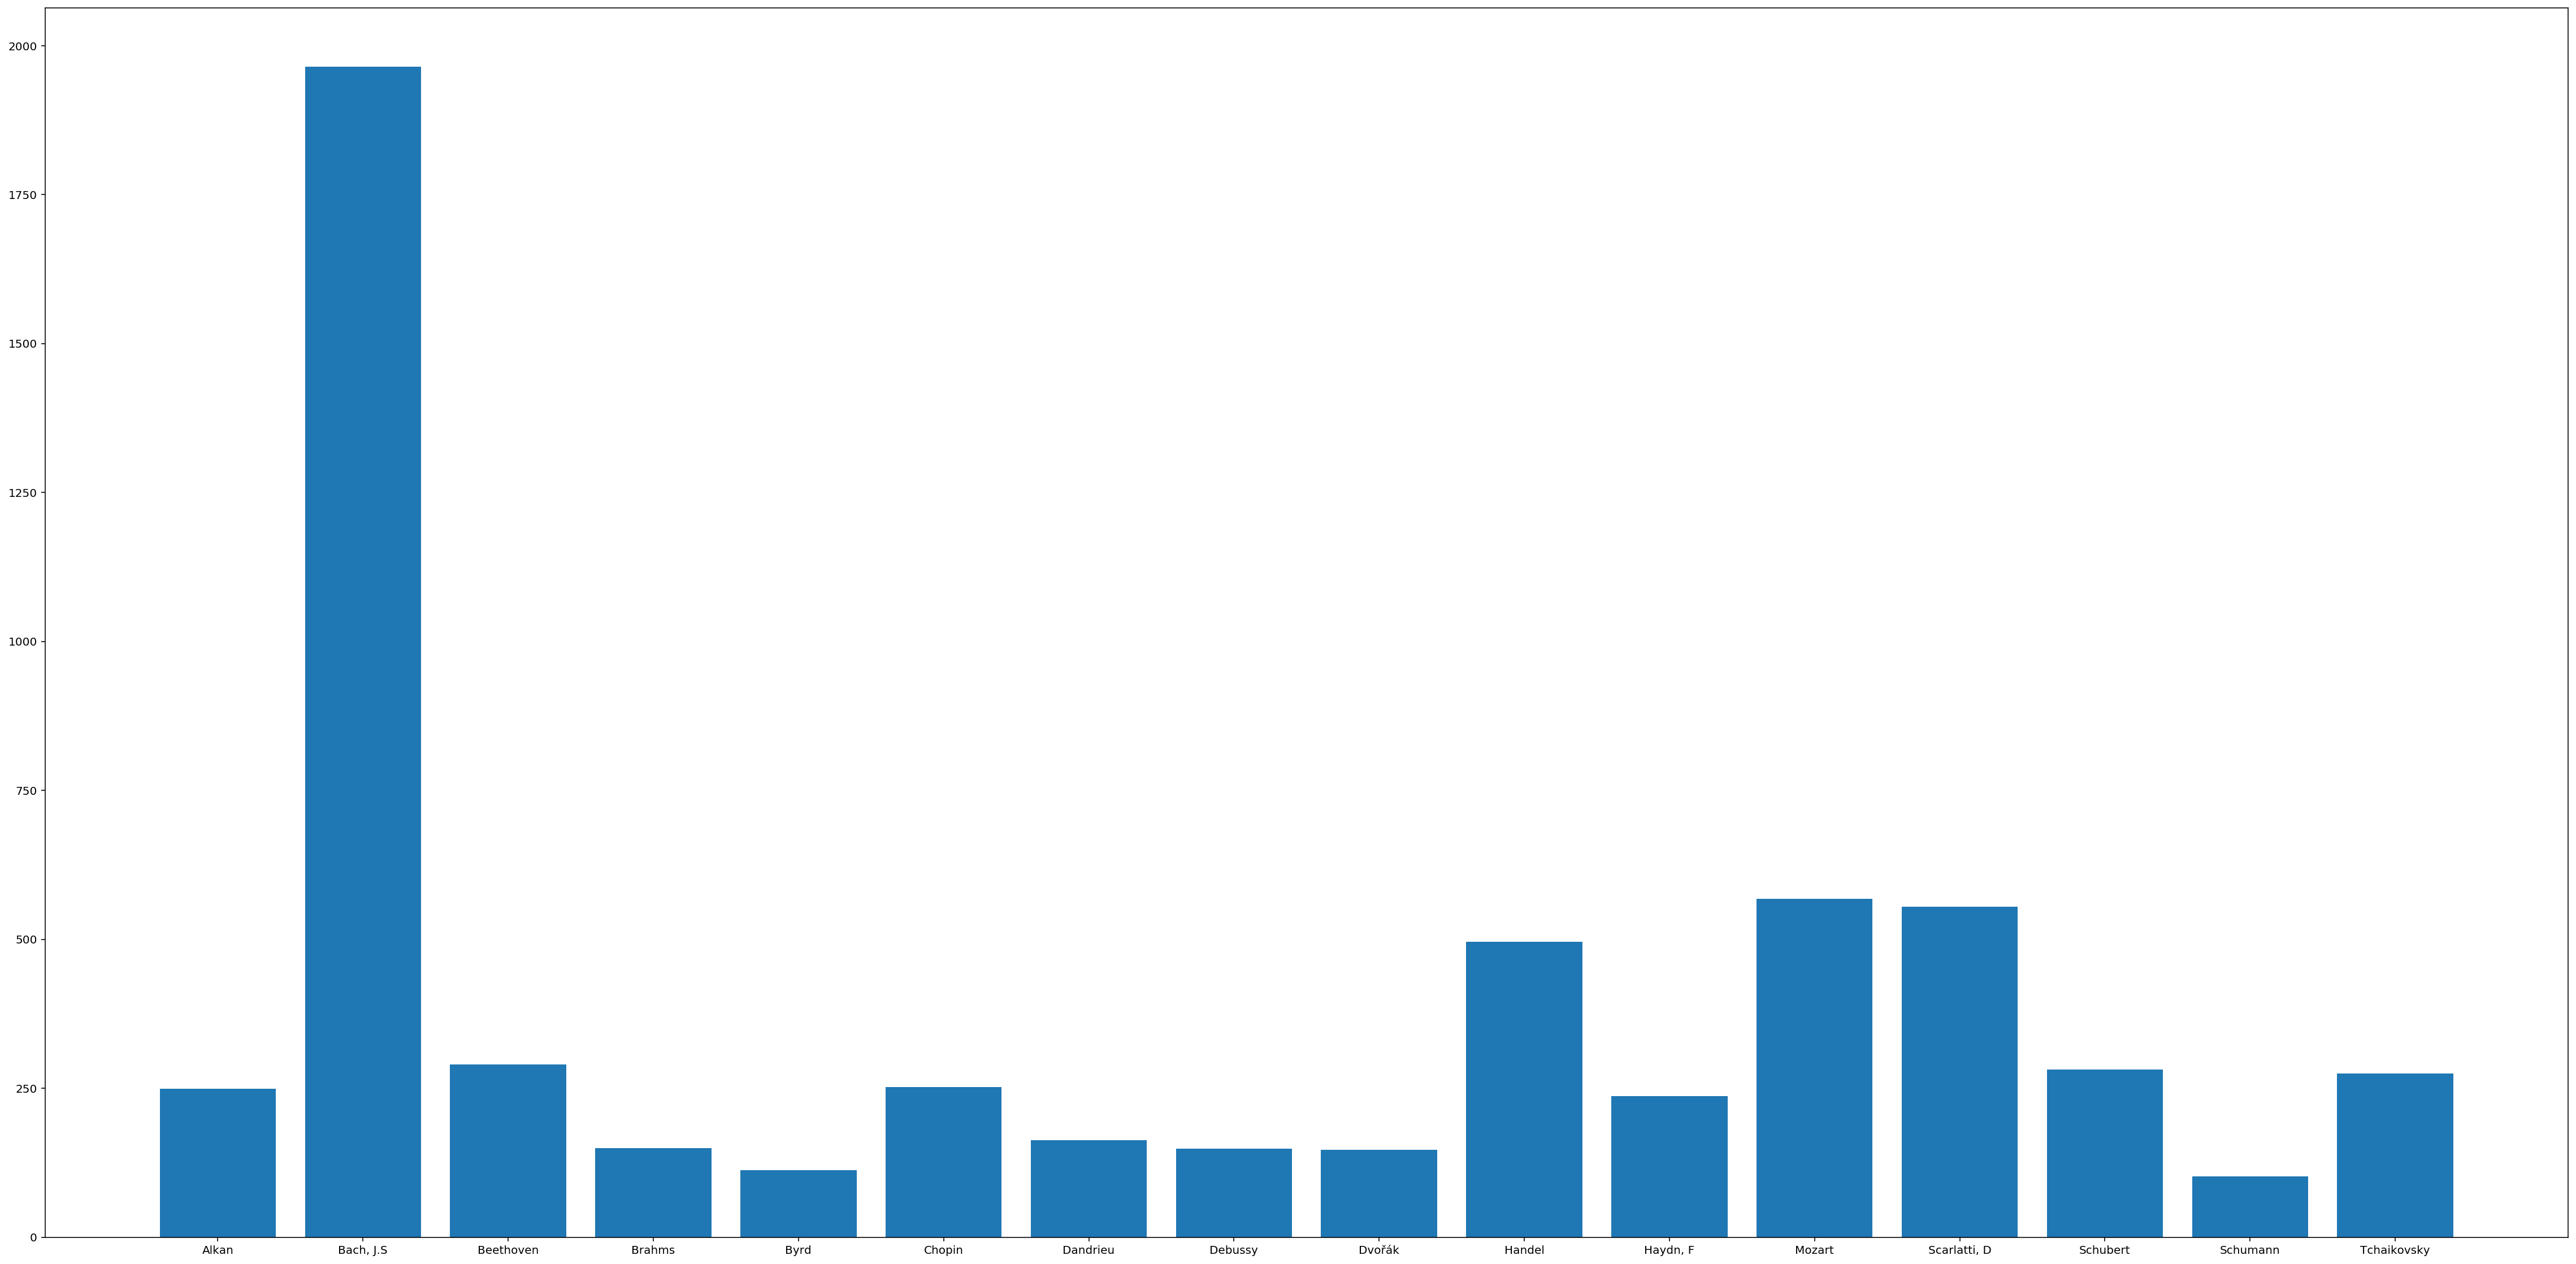

In [3]:
import random
from collections import Counter
import matplotlib.pyplot as plt
c = Counter([i["composer"] for i in music]).items()
fig, ax = plt.subplots(figsize=(40, 20))
c = dict(c)

# discard composers with less than 100 pieces
music = [piece for piece in music if c[piece["composer"]]>=100]
print(len(music))

print(c)
c = dict((i,j) for i,j in c.items() if j>=100)
ax.bar(c.keys(), c.values())
print(c)

In [4]:
# one-time terminal
import os, random
from unidecode import unidecode
random.seed(42)
sampler = random.sample(music, 200)
if not os.listdir("midi_files"):
  for i, piece in enumerate(tqdm(music)):
    track = Track(np.array(piece["piece"].todense())*127)
    Multitrack(tracks=[track], name=f'piece {i}, by {piece["composer"]}').write(f"midi_files/{i:04d}.midi")

In [5]:
from tqdm.notebook import *
import os
if False:
    for i in trange(5992):
        src = f'C:\\Users\\user\\Downloads\\classicall\\midi_files\\{i:04d}.midi'
        target = f'C:\\Users\\user\\Downloads\\classicall\\mxl_files\\{i:04d}.mxl'
        os.system(f'start "" "C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe" {src} --export-to {target}')

In [6]:
for dire, length in zip(('midi_files', 'mxl_files'), (9, 8)):
    for file in tqdm(os.listdir(dire)):
        if len(file) != length:
            print(file)
            os.system(f'del C:\\Users\\user\\Downloads\\classicall\\{dire}\\{file}')

In [7]:
random.seed(42)
#if True:
composers = set(piece["composer"] for piece in music)
pieces_by_composer = dict((composer, []) for composer in composers)
for i, piece in enumerate(music):
    pieces_by_composer[piece["composer"]].append(i)

composers = selected_composers = ("Bach", "Mozart", "Beethoven", "Debussy")
pieces_by_composer["Bach"] = pieces_by_composer["Bach, J.S"].copy()
del pieces_by_composer["Bach, J.S"]

if True:
    #i = 0
    with open('mxl-list.txt', 'w') as file:
        for composer in selected_composers:
            for piece in pieces_by_composer[composer]:
                #os.system(f'cp midi_files/{piece:04d}.midi midi_files/{i:03d}.midi')
                #os.system(f'cp mxl_files/{piece:04d}.mxl mxl_files/{i:03d}.mxl')
                file.write(f'{composer}_{piece:03d}.mxl\n')
                #i += 1

random.seed(42)
music = [music[piece] for composer in selected_composers for piece in pieces_by_composer[composer]]
for piece in music:
    if piece["composer"]=='Bach, J.S': piece["composer"] = 'Bach'
print(len(music))

random.seed(42)
print( [piece for composer in composers for piece in pieces_by_composer[composer]])
    #len(music)
    # random.sample(pieces_by_composer[composer], 50)
# in few_midi_files, 000.midi to 049.midi are by Bach,  050.midi to 099.midi by Mozart
#                    100.midi to 149.midi by Beethoven, 150.midi to 199.midi by Debussy

2972
[249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,

In [8]:
# one-time terminal
if False:
    with open('mxl-list.txt', 'w') as file:
      for i, piece in enumerate(music):   
        piece["composer"] = unidecode(piece["composer"])
        file.write(f'{piece["composer"]}_{i:04d}.mxl\n')
        


# Visualisation

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2886b785bc8>)

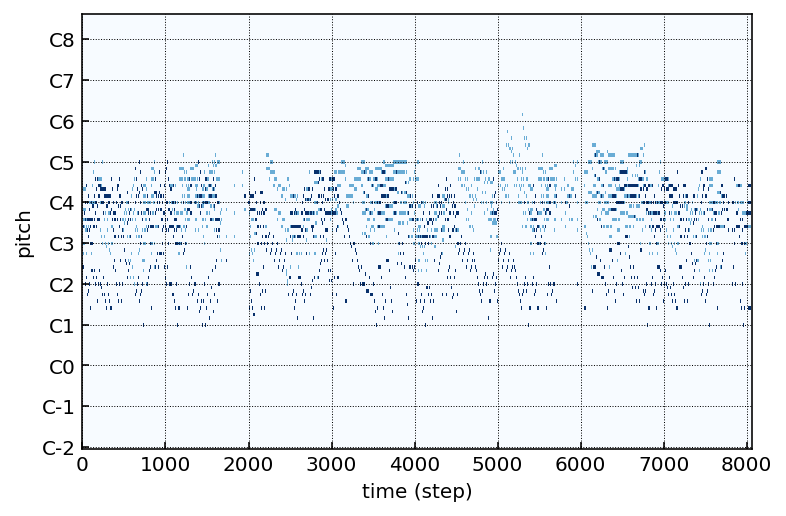

In [11]:
import matplotlib.pyplot as plt
piece = Track(np.array(music[0]["piece"].todense()))
plot(piece)

In [12]:
# playing around with pieces: keep, may be useful for prez
# source: ____
toPlay = False
if toPlay:
  import itertools
  from scipy.sparse import vstack
  import tqdm
  num_composers = 40
  chunk_size = 1024
  groups = itertools.groupby(sorted(music, key=lambda x: x["composer"]), lambda x: x["composer"])
  segments = []
  for composer, pieces in tqdm.tqdm_notebook(groups, total=num_composers):
      pieces_list = list(i["piece"].tocsr() for i in pieces)
      n = sum([i.shape[0] for i in pieces_list])//chunk_size
      if n!=0:
          trimmed_concat  = vstack(pieces_list)[:chunk_size*n]
          composer_segs = [(trimmed_concat[i:i+chunk_size], composer) for i in range(0,n*chunk_size,chunk_size)]
          segments.extend(composer_segs)
  random.shuffle(segments)
##################################################
from pypianoroll import Multitrack, Track
import pygame

def write_midi(arr, filename):
    Multitrack(tracks=[Track(arr*127)]).write(filename) # why *127? I don't understand
def play(filename):
    pygame.mixer.init()
    pygame.mixer.music.load(filename)
    # warning: doesn't work on Google Colab, works in local .ipynb
    pygame.mixer.music.play()
def test(num):
    answers = []
    for seg, comp in segments[:num]:
        write_midi(seg.toarray(), "temp2.mid")
        play("temp.mid")
        inp = input("Who was it?")
        if inp=="quit":
            break
        if len(inp)>=3 and inp.lower() in comp.lower():
            print(f"Correct the composer was {comp}")
            answers.append((comp, True))
        else:
            print(f"Incorrect the composer was {comp}")
            answers.append((comp, False))
    return answers
#test(7)

# 1. `pretty-midi`

In [13]:
import pretty_midi
# source: https://github.com/sandershihacker/midi-classification-tutorial/blob/master/midi_classifier.ipynb
def get_features(path):
    """
    This function extracts the features from a midi file when given its path.
    
    @input path: The path to the midi file.
    @type path: String
    
    @return: The extracted features.
    @rtype: List of float
    """
    #try:
    file = pretty_midi.PrettyMIDI(path)
    
    tempo = file.estimate_tempo()
    num_sig_changes = len(file.time_signature_changes)
    resolution = file.resolution
    ts_changes = file.time_signature_changes
    ts_1 = 4
    ts_2 = 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    return [tempo, num_sig_changes, resolution, ts_1, ts_2]
    #except Exception as e:
    #    print(e)
    #    return None

# original dataset doesn't have time signature data, and we can't find a package
#   that guesses it - oof
attr_lists = [[] for i in range(5)]
for i, piece in enumerate(music):
  for i, attr in enumerate(get_features(f'midi_files/{i:03d}.midi')):
    attr_lists[i].append(attr)
  if i==0:break

df = pd.DataFrame({
          'composer': [piece["composer"] for piece in music],
          'tempo': attr_lists[0],  
          'num_sig_changes': attr_lists[1], 
          'resolution': attr_lists[2], 
          'ts_1': attr_lists[3], 
          'ts_2': attr_lists[4],       
}, index=None)

FileNotFoundError: [Errno 2] No such file or directory: 'midi_files/000.midi'

In [ ]:
df.describe()
df.assign(index=df.groupby('composer').cumcount()).pivot('index','composer','tempo').plot(kind='box')
# https://stackoverflow.com/questions/48712274/matplotlib-box-plot-for-each-category#48712368

# Classification from attributes

In [ ]:
##################
# VISUALISATION
##################
from pypianoroll.metrics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def dict_(): return dict((composer, []) for composer in composers)
arr, e, npu, npc, q, p, dip, isr, lr =  dict_(), dict_(), dict_(), dict_(), dict_(), dict_(), dict_(), dict_(), dict_()
# empty_beat rate, number of pitches used, number of pitch classes, qualified note rate, polyphonic rate, _, _, length
ear = []
npuar = []
npcar = []
par = []
israr = []
lar = []
traits = pd.DataFrame

for piece in tqdm(music):
    arr = np.array(piece["piece"].todense())
    composer = piece["composer"]
    e[composer] += [empty_beat_rate(arr, 4)] # need time sig
    npu[composer] += [n_pitches_used(arr)]
    npc[composer] += [n_pitch_classes_used(arr)]
    #q[composer] += [qualified_note_rate(arr)]
    p[composer] += [polyphonic_rate(arr)]
    #dip[composer] += [drum_in_pattern_rate(arr, 4)]
    isr[composer] += [in_scale_rate(arr)]
    lr[composer] += [arr.shape[0]]

    ear.append(e[composer][-1])
    npuar.append(npu[composer][-1])
    npcar.append(npc[composer][-1])
    par.append(p[composer][-1])
    israr.append(isr[composer][-1])
    lar.append(lr[composer][-1])
    #print(f'{polyphonic_rate(, beat_resolution=4):.3f}')

import matplotlib.pyplot as plt
'''plt.hist(e)
plt.figure(); plt.hist(npu)
plt.figure(); plt.hist(npc)
plt.figure(); plt.hist(p)
plt.figure(); plt.hist(isr)'''

for set_ in (e, npu, npc, p, isr, lr):
    #plt.figure(figsize=(20,5))
    plt.figure()
    plt.boxplot(set_.values(), labels=set_.keys())

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import *
from sklearn import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import scipy

X = pd.DataFrame({
    'e': ear,
    'npu': npuar,
    'npc': npcar,
    'p': par,
    'isr': israr,
    'tempo': df['tempo'],
    'l': lar,
})

with open('indices.pickle', 'wb') as file:
    X = (X-X.mean()) / X.std()
    pickle.dump(X, file)


y = pd.DataFrame({
    'composer': [piece["composer"] for piece in music],
})

print('SPLITTING INTO TRAIN AND TEST')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


model = MLPClassifier()
model.fit(X_train, y_train)
print('score is', model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
raise ValueError('Don\'t run again')
print('CROSS_VAL_SCORE')
names = ['MLP', 'SVC', 'LinSVC', 'LogisticRegression', 'KNeighborsClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

param_spaces = [
    {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    },
    {'C': scipy.stats.expon(scale=100).rvs(4), 'gamma': scipy.stats.expon(scale=.1).rvs(4),
          'kernel': ['rbf'], 'class_weight':['balanced', None]},
    {'penalty': ['l1','l2'], 'C': 10.0 ** np.arange(-3, 4)},
    {'penalty': ['l1','l2'], 'C': 10.0 ** np.arange(-3, 4)},
    {'n_neighbors': [1, 2, 3, 4, 6, 8, 11, 20, 40], 'weights': ['distance', 'uniform'], 'p': [1, 2, 3]},
    {'n_estimators': [100, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10],},
    {
        "n_estimators":[5,50,250,500],
        "max_depth":[1,3,5,7,9],
        "learning_rate":[0.01,0.1,1,10,100]
    } # https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
]

models = [
    MLPClassifier(),
    svm.SVC(),
    svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
    linear_model.LogisticRegression(penalty='l2', C=100, tol=1, multi_class='multinomial', solver='sag'),
    neighbors.KNeighborsClassifier(weights='distance'),
    #naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False),
    RandomForestClassifier(n_estimators=1000, random_state=42),
    GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4, max_depth=None, random_state=2,
                   min_samples_split=5),
]
average_scores = []
for name, param_space, model_cv in zip(tqdm(names, unit='model'), param_spaces, models):
    np.random.seed(42)
    clf = GridSearchCV(model_cv, param_space, n_jobs=-1, refit=True, verbose=3)
    clf.fit(X, y)
    print('Best parameters found:\n', clf.best_params_)

    #scores = cross_val_score(model_cv, X, y)
    #print(f'{name:^24} | score = {sum(scores)/len(scores):.3f}\n')
    
    #print(' '.join(f'{score:.3f}' for score in scores))
    print(f'{name:^24} | score = {clf.best_score_:.3f}\n')
    average_scores.append(clf.best_score_)

print(f'''\n\nWe get a best average classification accuracy of {max(average_scores):.3f}.
Compare this with the score for tf-idf on chord frequency later.''')

In [ ]:
##########################
####### RFC & GBC ########
##########################
print('CROSS_VAL_SCORE')
names = [
    'RandomForestClassifier',
    'GradientBoostedClassifier',
]

import random
from math import log
from sklearn.model_selection import RandomizedSearchCV
class Estimator:
    def __init__(self, start, end, num=1000):
        self.base = 2
        self.start, self.end, self.num = log(start, self.base), log(end, self.base), num
        
    def rvs(self, **params):
        return int(random.choice(self.base ** np.linspace(self.start, self.end, num=self.num)))
    
'''{
        'n_estimators': Estimator(10.0, 2.0, 3.3), #10.0 ** np.linspace(2.0, 3.3, 0.01),
        'max_depth': Estimator(5.0, 1.0, 2.2),#[5, 8, 15, 25, 30],
        'min_samples_split': Estimator(2.0, 1.0, 6.3), #[2, 5, 10, 15, 100],
        'min_samples_leaf': Estimator(2.0, 0.0, 3.4), #[1, 2, 5, 10],
    },'''      

param_spaces = [
    
    {
        "n_estimators": Estimator(40, 2000), #[5,50,250,500],
        "max_depth": [None] + list(range(1,12)),
        "learning_rate": 0.1 ** np.linspace(0.0, 4.0, num=1000)
    } # https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
]

models = [
    #MLPClassifier(),
    #svm.SVC(),
    #svm.LinearSVC(penalty='l2', C=5, loss='hinge'),
    #linear_model.LogisticRegression(penalty='l2', C=100, tol=1, multi_class='multinomial', solver='sag'),
    #neighbors.KNeighborsClassifier(weights='distance'),
    #naive_bayes.MultinomialNB(alpha=0.00001, fit_prior=False),
    #RandomForestClassifier(n_estimators=1000, random_state=42),
    GradientBoostingClassifier(random_state=2),
]
average_scores = []
for name, param_space, model_cv in zip(tqdm(names, unit='model'), param_spaces, models):
    np.random.seed(42)
    clf = RandomizedSearchCV(model_cv, param_space, n_jobs=-1, n_iter=500, verbose=3)
    clf.fit(X, y)
    print('Best parameters found:\n', clf.best_params_)

    #scores = cross_val_score(model_cv, X, y)
    #print(f'{name:^24} | score = {sum(scores)/len(scores):.3f}\n')
    
    #print(' '.join(f'{score:.3f}' for score in scores))
    print(f'{name:^24} | score = {clf.best_score_:.3f}\n')
    average_scores.append(clf.best_score_)

print(f'''\n\nWe get a best average classification accuracy of {max(average_scores):.3f}.
Compare this with the score for tf-idf on chord frequency later.''')

CROSS_VAL_SCORE


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s


In [196]:
##########################
######## MLP #############
##########################
print('CROSS_VAL_SCORE')
names = ['MLP',] # 'SVC', 'LinSVC', 'LogisticRegression', 'KNeighborsClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

param_spaces = [
    {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['relu', 'logicstic', 'tanh'],
        'solver': ['adam'],
        'alpha': [0.0001, 0.003, 0.05],
        'learning_rate': ['constant'],
    },
]

models = [
    MLPClassifier(max_iter=2000),
]
#print(models[0].get_params()); raise Exception

average_scores = []
for name, param_space, model_cv in zip(tqdm(names, unit='model'), param_spaces, models):
    np.random.seed(42)
    clf = GridSearchCV(model_cv, param_space, n_jobs=-1, refit=True, verbose=5, cv=25)
    clf.fit(X, y)
    print('Best parameters found:\n', clf.best_params_)

    #scores = cross_val_score(model_cv, X, y)
    #print(f'{name:^24} | score = {sum(scores)/len(scores):.3f}\n')
    
    #print(' '.join(f'{score:.3f}' for score in scores))
    print(f'{name:^24} | score = {clf.best_score_:.3f}\n')
    average_scores.append(clf.best_score_)

print(f'''\n\nWe get a best average classification accuracy of {max(average_scores):.3f}.
Compare this with the score for tf-idf on chord frequency later.''')

CROSS_VAL_SCORE


Fitting 25 folds for each of 27 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  3.0min finished
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
          MLP            | score = 0.695




We get a best average classification accuracy of 0.695.
Compare this with the score for tf-idf on chord frequency later.


# 2. tf-idf by chord frequency

# 3. Characterisation (To-do)
Look at which features are most important in classifying the music/try to *explain* the classification. (e.g., look at the chord or pair of chords for tf-idf that match to each composer)


Change a chord or two and see if the classification changes. (can extend to adverserial neural networks that mess with the pieces and make them misclassified if we really, really have time)

Pass some *very* short/interesting pieces (like the school song) through the classifier, look at the labels, and see what that can tell us
